<font size="4" face="verdana" color="red"> Brainery Byte
<hr></font>
<font size="6" face="verdana" color="blue">Sections in OpenSees: <br>
    <b>MOMENT-CURVATURE & P-M INTERACTION </b><br>
    <br>
    <li>Elastic Section </li>
    <li> Uncoupled Section (with Section Aggregator) </li>

</font><p>

<font size="4" face="verdana" color="black">
 R210704 <br>
 Silvia Mazzoni, 2021 <br>
      silviamazzoni@yahoo.com <br>

<br>
NOTES:
    <ol>
        <li> TENSION IS POSITIVE, COMPRESSION IS NEGATIVE, throughout!
        <li> This script takes advantage of dictionaries as a data structure to store model info. Using this apparent extra step allows you to store the information of your model in case you need to use it in post-processing. For example, it allows you to draw the fiber sections</li>
        <li>Yes this WebApp uses function eSEESminiPy package to make the tool easier to use</li>
    </ol>
</font>
    
<BR>
<font size="4" face="verdana" color="black">
    <b>Process Outline:</b>
<ol type="1">
  <li>Initialize Pyton -- add necessary libraries and notebook setup</li>
  <li>Define Units (optional, but handy)</li>
  <li>Initialize javascript
  <li>Initialize Arrays Variables</li>
  <li>Define python utilities: define functions that make programming easier</li>
  <li>Define Normalized Loading Cycles for Material and Section Testing</li>
  <li>Start up OpenSees</li>
    <br>

  <li>For each Elastic Uniaxial section:</li>
    <ol type = "a">
        <li> Define Elastic-Section Properties</li>
        <li> Define OpenSees uniaxial elastic section</li>
    </ol>
  <li>For each Uncoupled section:</li>
    <ol type = "a">
         <li> Define Elastic-Section Properties</li>
         <li> Define an Elastic/Inelastic uniaxial material for each behavior (P,Vy,Vz,T,My,Mz)</li>
         <li> Use OpenSees aggregator section to combine the individual behaviors into a single section</li>
    </ol>
    <br>
          <li> For each Loading direction (z,y):</li>
          <ol>
              <li>Test Moment-Curvature response Section at a unique axial load</li>
              <li> P-M interaction Analysis: Moment-Curvature response at a series of axial loads</li>
          </ol>

</ol>
NOTE: You will see that these sections have the same Mom-Curvature response at any axial load and a rectangular P-M Interaction Diagram --> no interaction
</font>
    
When you are done, you can print the notebook. You can also download the notebook to your local computer.

Because we are working in Binder, and Binder sessions are meant to be ephemeral, it is not possible for you to save any changes you make to your Jupyter Notebook. If you do make changes or notes, you will need to download the notebook to your own computer by clicking File > Download as > Notebook (.ipynb). The only way you will be able to run these is if you have the appropriate software to run Jupyter Notebooks in Python and pip install OpenSeesPy and eSEESminiPy in your Python configuration. You may view my videos on how to install Anaconda, Jupyter Notebooks and OpenSeesPy (https://www.youtube.com/c/silviasbrainery).
    
This Code has been developed by Silvia Mazzoni. Please acknowledge this in your scripts, when applicable

In [1]:
# Initalize Python Libraries
import openseespy.opensees as ops
import eSEESminiPy
import matplotlib.pyplot as plt
import math

In [2]:
%%javascript
// expand output box so graphs are viewed in notebook properly
IPython.OutputArea.auto_scroll_threshold = 1000;

<IPython.core.display.Javascript object>

In [3]:
# define UNITS ----------------------------------------------------------------------------
inch  = 1.  # define basic units -- output units
kip  = 1. # define basic units -- output units
sec  = 1. # define basic units -- output units
LunitTXT  = 'inch' # define basic-unit text for output
FunitTXT  = 'kip' # define basic-unit text for output
TunitTXT  = 'sec' # define basic-unit text for output
ft  = 12.*inch # define engineering units
ksi  = kip/math.pow(inch,2)
psi  = ksi/1000.
lbf  = psi*inch*inch # pounds force
pcf  = lbf/math.pow(ft,3) # pounds per cubic foot
psf  = lbf/math.pow(ft,3) # pounds per square foot
inch2  = inch*inch # inch^2
inch4  = inch*inch*inch*inch # inch^4
cm  = inch/2.54 # centimeter, needed for displacement input in MultipleSupport excitation
PI  = 2*math.asin(1.0) # define constants
g  = 32.2*ft/math.pow(sec,2) # gravitational acceleration
Ubig  = 1.e10 # a really large number
Usmall  = 1/Ubig # a really small number
inchInv = 1/inch;


In [4]:
# Initialize Arrays and variables
global matTag
matTag = 0
secTag = 0
SectionTagMap = {}
MaterialTagMap = {}
allSectionData = {}
MomCurvData = {}
plt.close('all')
# Define bending directions for moment-curvature analysis
# you may remove either y or z if needed.
BendingDirectionList = ['z','y']

In [5]:
# UTILITIES
# Define some local handy procs
def addMaterial(MaterialType,InputArray):
    global matTag
    matTag += 1
    ops.uniaxialMaterial(MaterialType,matTag,*InputArray)
    return matTag


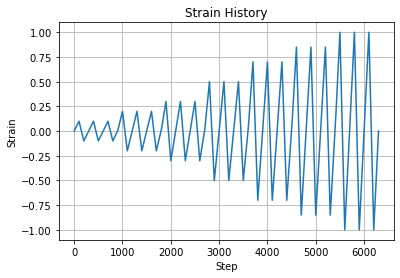

In [6]:
# Define Normalized Loading Cycles for Material and Section Testing.

# These cycles are normalized to have a maximum value of 1.0
# You can later change the amplitude factor depending on the application
peaksArray = [0.1,0.2,0.3,0.5,0.7,0.85,1.0]
nCycles = 3
nSteps = 100
StrainSeries = eSEESminiPy.defineStrainHistory(peaksArray,nCycles,nSteps)
eSEESminiPy.plotYoneList(StrainSeries,title='Strain History',Ylabel='Strain')


In [7]:
# Start-up OpenSees
ops.wipe()
Dim = '3D'
ops.model('basic','-ndm',3,'-ndf',6)

############################################################################################################<p>
<font size="6" face="verdana" color="blue">Elastic Section <br></font>
############################################################################################################

In [8]:
################################################################################################
### ELASTIC SECTION
################################################################################################
thisSectionLabel = 'Elastic'

# initialize Section Data
thisSectionData = {}
thisMaterialTagMap = {}
secTag += 1
SectionTagMap[thisSectionLabel] = secTag
thisSectionData['SectionTag'] = secTag

#elastic-Section Properties:
YoungsModulus = 2.900E+04*ksi
ShearModulus = 1.115E+04*ksi
TorsionInertia = 3.492E+01*inch4
Axis2Inertia = 9.310E+02*inch4
Axis3Inertia = 2.400E+03*inch4
AxialArea = 5.680E+01*inch2
Axis2ShearArea = 1.378E+01*inch2
Axis3ShearArea = 3.771E+01*inch2

# Define OpenSees Section
ops.section('Elastic', secTag, YoungsModulus, AxialArea, Axis3Inertia, Axis2Inertia, ShearModulus, TorsionInertia)

# add to all
allSectionData[thisSectionLabel] = thisSectionData

In [9]:
## RUN Moment-Curvature Analysis of Fiber Section
### MOMENT-CURVATURE ANALYSIS

axialLoad = 0
ampFactor = 0.01
testSectionLabel = 'Elastic'
for BendingDirection in BendingDirectionList:
    MomCurvData[testSectionLabel + BendingDirection] = eSEESminiPy.runMomentCurvature(SectionTagMap[testSectionLabel],axialLoad,StrainSeries,100,Dim+BendingDirection,ampFactor)
    


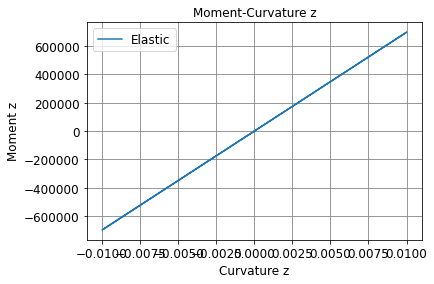

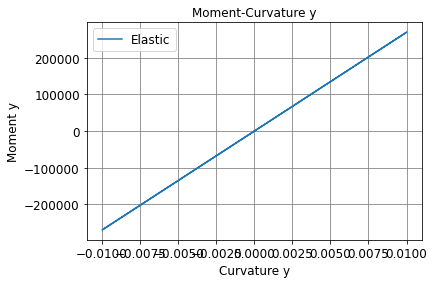

In [10]:
### Plot Moment-Curvature Responses
for BendingDirection in BendingDirectionList:
    thisFig, axModel = plt.subplots()
    line, = axModel.plot(MomCurvData[testSectionLabel + BendingDirection]['Curvature'], MomCurvData[testSectionLabel + BendingDirection]['Moment'], label =testSectionLabel)
    eSEESminiPy.formatAx(axModel,'Moment-Curvature ' + BendingDirection,'Curvature ' + BendingDirection,'Moment ' + BendingDirection)



In [11]:
# perform P-M Interaction Analysis
testSectionLabel = 'Elastic'
PmaxNeg = -100
PmaxPos = 100

NaxialPoints = 10
PaxialList = []
for i in range(NaxialPoints):
    PaxialList.append(PmaxNeg - i*PmaxNeg/NaxialPoints)
for i in range(NaxialPoints+1):
    PaxialList.append(i*PmaxPos/NaxialPoints)

KappaMax = 0.03

PMinteraxData = {}
for thisSec in [testSectionLabel]:
    PMinteraxData[thisSec] = {}
    for BendingDirection in BendingDirectionList:
        PMinteraxData[thisSec][BendingDirection] = {}
        for CurvatureSign in [+1,-1]:
            PMinteraxData[thisSec][BendingDirection][CurvatureSign] = {}
            for thisAxial in PaxialList:
                PMinteraxData[thisSec][BendingDirection][CurvatureSign][thisAxial] = eSEESminiPy.runMomentCurvature(SectionTagMap[thisSec],thisAxial,CurvatureSign*KappaMax,100,Dim+BendingDirection)


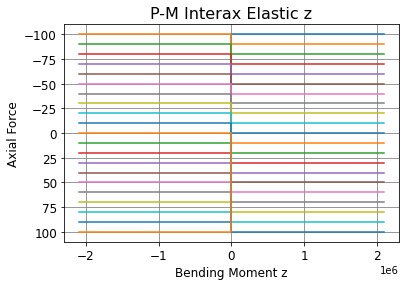

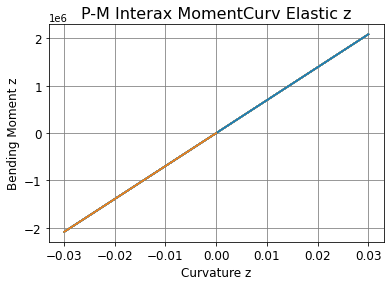

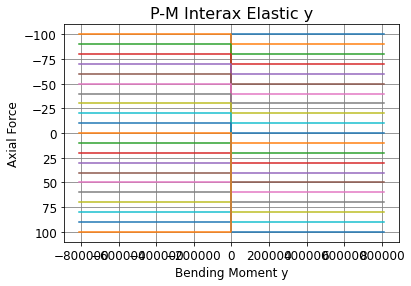

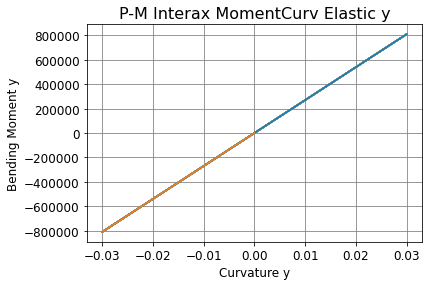

In [12]:
# Plot P-M Interaction Data
for thisSec in PMinteraxData.keys():
    for BendingDirection in PMinteraxData[thisSec].keys():
        thisFig, axModel = plt.subplots()
        thisFig2, axModel2 = plt.subplots()
        for CurvatureSign in PMinteraxData[thisSec][BendingDirection].keys():
            for thisAxial in  PMinteraxData[thisSec][BendingDirection][CurvatureSign].keys():
                thisMomCurvData = PMinteraxData[thisSec][BendingDirection][CurvatureSign][thisAxial]
                line, = axModel.plot(thisMomCurvData['Moment'], thisMomCurvData['AxialForce'])
                line, = axModel2.plot(thisMomCurvData['Curvature'], thisMomCurvData['Moment'])
        eSEESminiPy.formatAx(axModel,'P-M Interax ' + thisSec + ' ' + BendingDirection,'Bending Moment ' + BendingDirection,'Axial Force',16,12)
        eSEESminiPy.formatAx(axModel2,'P-M Interax MomentCurv ' + thisSec + ' ' + BendingDirection ,'Curvature ' + BendingDirection,'Bending Moment ' + BendingDirection,16,12)
        eSEESminiPy.reverseYaxis(axModel) # plot Axial Force Compression up
plt.show()


############################################################################################################<p>
<font size="6" face="verdana" color="blue">Uncoupled Section <br></font>
############################################################################################################

In [13]:
################################################################################################
### UNCOUPLED SECTION
################################################################################################
thisSectionLabel = 'Uncoupled'

# initialize Section Data
thisSectionData = {}
thisMaterialTagMap = {}
secTag += 1
SectionTagMap[thisSectionLabel] = secTag
thisSectionData['SectionTag'] = secTag

#elastic-Section Properties:
YoungsModulus = 2.900E+04*ksi
ShearModulus = 1.115E+04*ksi
AxialArea = 2.770E+01*inch2
Axis2ShearArea = 1.319E+01*inch2
Axis3ShearArea = 1.241E+01*inch2
TorsionInertia = 3.810E+00*inch4
Axis2Inertia = 1.240E+02*inch4
Axis3Inertia = 3.270E+03*inch4


# Elastic Behaviors:
thisMaterialTagMap = {}
thisMaterialTagMap['P'] = addMaterial('Elastic',[YoungsModulus*AxialArea])
thisMaterialTagMap['Vy'] = addMaterial('Elastic',[ShearModulus*Axis2ShearArea])
thisMaterialTagMap['Vz'] = addMaterial('Elastic',[ShearModulus*Axis3ShearArea])
thisMaterialTagMap['T'] = addMaterial('Elastic',[ShearModulus*TorsionInertia])
thisMaterialTagMap['My'] = addMaterial('Elastic',[YoungsModulus*Axis2Inertia])
#Inelastic Behavior:
PositiveYAction = 1.390E+04*kip*inch
PositiveXDefo = 2.932E-03*inchInv
PositiveEnvelopeData = [PositiveYAction,PositiveYAction/(YoungsModulus*Axis3Inertia),1.00000001*PositiveYAction,PositiveXDefo]
NegativeEnvelopeData = [-PositiveYAction,-PositiveYAction/(YoungsModulus*Axis3Inertia),-1.00000001*PositiveYAction,-PositiveXDefo]

# hyteretic-material properties
[pinchX,pinchY] = [1,1]
[damage1,damage2] = [0.0,0.0]
beta = 0.5
hystereticData = [pinchX,pinchY,damage1,damage2,beta]
thisMaterialTagMap['Mz'] = addMaterial('Hysteretic',[*PositiveEnvelopeData,*NegativeEnvelopeData,*hystereticData])

# create input for Aggregator Section
SectionInputArray = []
for (thisLabel) in ['P','Vy','Vz','T','My','Mz']:
    SectionInputArray.append(thisMaterialTagMap[thisLabel])
    SectionInputArray.append(thisLabel)
thisSectionData['SectionInputArray'] = SectionInputArray
print('OpenSees Input Data:' )
print(SectionInputArray)

ops.section('Aggregator', secTag, *SectionInputArray)

# Add material maps to all
MaterialTagMap[thisSectionLabel] = thisMaterialTagMap

# add to all
allSectionData[thisSectionLabel] = thisSectionData

OpenSees Input Data:
[1, 'P', 2, 'Vy', 3, 'Vz', 4, 'T', 5, 'My', 6, 'Mz']


In [14]:
## RUN Moment-Curvature Analysis of Fiber Section
### MOMENT-CURVATURE ANALYSIS

axialLoad = 0
ampFactor = 0.01
testSectionLabel = 'Uncoupled'
for BendingDirection in BendingDirectionList:
    MomCurvData[testSectionLabel + BendingDirection] = eSEESminiPy.runMomentCurvature(SectionTagMap[testSectionLabel],axialLoad,StrainSeries,100,Dim+BendingDirection,ampFactor)
    


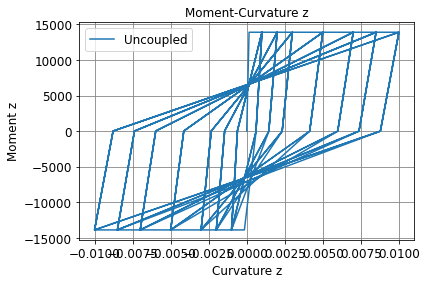

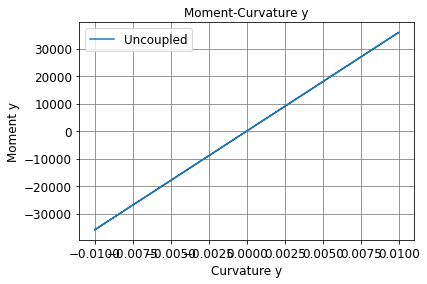

In [15]:
### Plot Moment-Curvature Responses
for BendingDirection in BendingDirectionList:
    thisFig, axModel = plt.subplots()
    line, = axModel.plot(MomCurvData[testSectionLabel + BendingDirection]['Curvature'], MomCurvData[testSectionLabel + BendingDirection]['Moment'], label =testSectionLabel)
    eSEESminiPy.formatAx(axModel,'Moment-Curvature ' + BendingDirection,'Curvature ' + BendingDirection,'Moment ' + BendingDirection)



In [16]:
# perform P-M Interaction Analysis
testSectionLabel = 'Uncoupled'
PmaxNeg = -100
PmaxPos = 100

NaxialPoints = 10
PaxialList = []
for i in range(NaxialPoints):
    PaxialList.append(PmaxNeg - i*PmaxNeg/NaxialPoints)
for i in range(NaxialPoints+1):
    PaxialList.append(i*PmaxPos/NaxialPoints)

KappaMax = 0.03

PMinteraxData = {}
for thisSec in [testSectionLabel]:
    PMinteraxData[thisSec] = {}
    for BendingDirection in BendingDirectionList:
        PMinteraxData[thisSec][BendingDirection] = {}
        for CurvatureSign in [+1,-1]:
            PMinteraxData[thisSec][BendingDirection][CurvatureSign] = {}
            for thisAxial in PaxialList:
                PMinteraxData[thisSec][BendingDirection][CurvatureSign][thisAxial] = eSEESminiPy.runMomentCurvature(SectionTagMap[thisSec],thisAxial,CurvatureSign*KappaMax,100,Dim+BendingDirection)


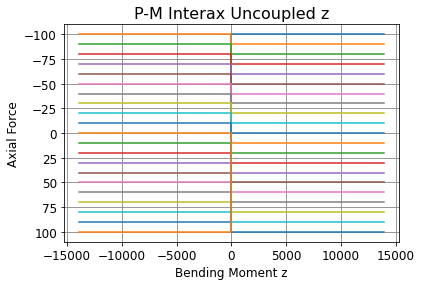

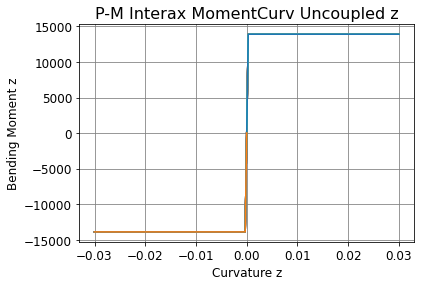

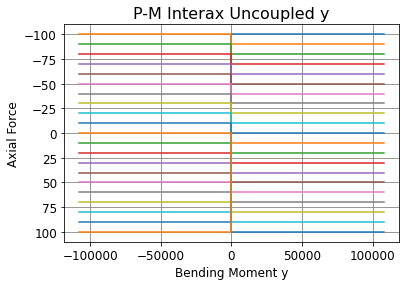

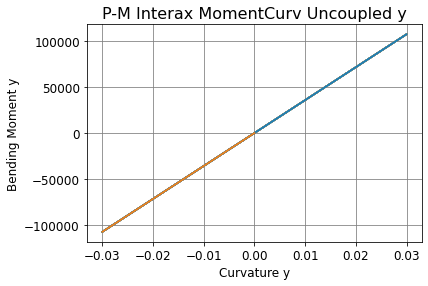

In [17]:
# Plot P-M Interaction Data
for thisSec in PMinteraxData.keys():
    for BendingDirection in PMinteraxData[thisSec].keys():
        thisFig, axModel = plt.subplots()
        thisFig2, axModel2 = plt.subplots()
        for CurvatureSign in PMinteraxData[thisSec][BendingDirection].keys():
            for thisAxial in  PMinteraxData[thisSec][BendingDirection][CurvatureSign].keys():
                thisMomCurvData = PMinteraxData[thisSec][BendingDirection][CurvatureSign][thisAxial]
                line, = axModel.plot(thisMomCurvData['Moment'], thisMomCurvData['AxialForce'])
                line, = axModel2.plot(thisMomCurvData['Curvature'], thisMomCurvData['Moment'])
        eSEESminiPy.formatAx(axModel,'P-M Interax ' + thisSec + ' ' + BendingDirection,'Bending Moment ' + BendingDirection,'Axial Force',16,12)
        eSEESminiPy.formatAx(axModel2,'P-M Interax MomentCurv ' + thisSec + ' ' + BendingDirection ,'Curvature ' + BendingDirection,'Bending Moment ' + BendingDirection,16,12)
        eSEESminiPy.reverseYaxis(axModel) # plot Axial Force Compression up
plt.show()


In [18]:
## This Code has been developed by Silvia Mazzoni. Please acknowledge this in your scripts, when applicable